# Urban spatial structure: cities comparison

In this notebook we show the comparison of all the analyzed cities.

Specifically we start by loading the users statistics and figures on stops and pois and we later focus on spatial structure.

**Note on data**

The data used in this notebook have been provided by [Quadrant](https://www.quadrant.io/) within the **Resilient Urban Planning Analysis Using Smartphone Location Data** project of the The World Bank / Global Facility for Disaster Reduction and Recovery ([GFDRR](https://www.gfdrr.org/en)) - contract number 7204724.

[Quadrant](https://www.quadrant.io/) (An Appen Company) is a global leader in mobile location data, POI data, and corresponding compliance services.  Quadrant provides anonymised location data and location-based business solutions that are fit for purpose, authentic, easy to use, and simple to organise. We offer data for almost all countries in the world, with hundreds of millions of unique devices and tens of billions of events per month, allowing our clients to perform location analyses, derive location-based intelligence, and make well-informed business decisions. Our data is gathered directly from first party opt-in mobile devices through a server-to-server integration with trusted publisher partners, delivering genuine and reliable raw GPS data unlike other location data sources relying heavily on Bidstream. Our consent management platform, QCMP, ensures that our data is compliant with applicable consent and opt-out provisions of data privacy laws governing the collection and use of location data.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime
import sys
import os
from shutil import rmtree
from dask.distributed import Client
from dask import dataframe as dd
import dask
import seaborn as sns
import statsmodels.api as sm
import pytz
import psutil
import multiprocessing
sns.set_context('notebook', font_scale=1.5)

dask.__version__

'2022.04.1'

We also import `mobilkit` as `mk` to gain access to all the librarie's capabilities.
We import some constant names of columns from the `dask_schemas` submodule as they will be useful later on.

In [2]:
import mobilkit as mk
from mobilkit.spatial import haversine_pairwise
from mobilkit.dask_schemas import (latColName, lonColName,
                                   uidColName, zidColName,
                                   accColName, utcColName,
                                   dttColName, durColName,
                                   locColName, ldtColName,
                                   medLatColName, medLonColName)
from mobilkit.viz import compareLinePlot

## Configuration

We start defining the cities to be loaded, where the data are and some auxiliary information for each city.

In [3]:
ROOT_IN_FOLDER = '/mnt/data/resilience_analyses'
OUT_FOLDER = '/mnt/data/resilience_analyses/comparison'

DATA_CITIES = {}

In [4]:
DATA_CITIES['mumbai'] = {
    'name': 'Mumbai',
    'population': 25632800,
    'aoi_radius_km': 60,
    'to_do': True,
}

DATA_CITIES['ankara'] = {
    'name': 'Ankara',
    'population': 5841050,
    'aoi_radius_km': 30,
    'to_do': True,
}

DATA_CITIES['riyadh'] = {
    'name': 'Riyadh',
    'population': 6623460,
    'aoi_radius_km': 40,
    'to_do': True,
}

DATA_CITIES['rio_de_janeiro'] = {
    'name': 'Rio de Janeiro',
    'population': 12545800,
    'aoi_radius_km': 50,
    'to_do': True,
}

DATA_CITIES['doha'] = {
    'name': 'Doha',
    'population': 2409370,
    'aoi_radius_km': 35,
    'to_do': True,
}

DATA_CITIES['dhaka'] = {
    'name': 'Dhaka',
    'population': 32033100,
    'aoi_radius_km': 40,
    'to_do': False,
}

DATA_CITIES['bogota'] = {
    'name': 'Bogota',
    'population': 10056200,
    'aoi_radius_km': 30,
    'to_do': False,
}

DATA_CITIES['buenos_aires'] = {
    'name': 'Buenos Aires',
    'population': 16877600,
    'aoi_radius_km': 50,
    'to_do': False,
}

DATA_CITIES['ho_chi_minh'] = {
    'name': 'Ho Chi Minh',
    'population': 16431400,
    'aoi_radius_km': 45,
    'to_do': False,
}

DATA_CITIES['johannesburg'] = {
    'name': 'Johannesburg',
    'population': 13609300,
    'aoi_radius_km': 45,
    'to_do': False,
}

In [5]:
os.makedirs(OUT_FOLDER, exist_ok=True)

## Create _Dask_ client

Here we create and connect to a dask client.
We just specify where we want Dask to store tmp files (the `tmp_dask_dir`) and the memory limit per worker.

In [6]:
tmp_dask_dir = '/mnt/dask_workplace/'
dask.config.set({'temporary_directory': tmp_dask_dir})
os.environ["DASK_TEMPORARY_DIRECTORY"] = tmp_dask_dir

In [7]:
n_proc = int(multiprocessing.cpu_count() / 2) - 1
mem_per_proc = psutil.virtual_memory().total * 1.3 / 1e9 / n_proc
client = Client(
    memory_limit='%.01fG'%mem_per_proc,
    n_workers=n_proc,
    threads_per_worker=2
               )
client

2022-05-18 10:23:50,377 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/dask_workplace/dask-worker-space/worker-p24zfk__', purging


<Client: 'tcp://127.0.0.1:39577' processes=23 threads=46, memory=162.80 GiB>

## Load the needed data

In [8]:
for city, data in DATA_CITIES.items():
    print(data['name'])
    path_users_stats = os.path.join(ROOT_IN_FOLDER, city, 'users_stats.pkl')
    data['users_stats_df'] = pd.read_pickle(path_users_stats)
    
    

    path_users_stop_locs = os.path.join(ROOT_IN_FOLDER, city, 'users_stop_locs_df')
    users_stop_locs_df = dd.read_parquet(path_users_stop_locs)
    n_locs = users_stop_locs_df.shape[0].compute()
    data['number_of_locations'] = n_locs
    
    path_user_locs_stats_hw_separated = os.path.join(ROOT_IN_FOLDER, city,
                                                     'user_locs_stats_hw_separated.pkl')
    data['user_locs_stats_hw_separated'] = pd.read_pickle(path_user_locs_stats_hw_separated)
    
    path_df_hw_locs_pd = os.path.join(ROOT_IN_FOLDER, city,
                                      'df_hw_locs_pd.pkl')
    data['df_hw_locs_pd'] = pd.read_pickle(path_df_hw_locs_pd)
    
    
    data['user_stats_table_df'] = pd.read_pickle(os.path.join(ROOT_IN_FOLDER, city,
                                                      'user_stats_table_df.pkl'))
    data['cleaned_user_stats_table_df'] = pd.read_pickle(os.path.join(ROOT_IN_FOLDER, city,
                                                              'cleaned_user_stats_table_df.pkl'))
    
    data['out_df_hw_locs'] = pd.read_pickle(os.path.join(ROOT_IN_FOLDER, city, 'out_df_hw_locs.pkl'))
    data['df_cnt_hw_locs'] = pd.read_pickle(os.path.join(ROOT_IN_FOLDER, city, 'out_df_cnt_hw_locs.pkl'))
    
    
    data['gdf'] = gpd.read_file(os.path.join(ROOT_IN_FOLDER, city,
                                             'gdf_landuse_rog.gpkg'))

Mumbai
Ankara
Riyadh
Rio de Janeiro
Doha
Dhaka
Bogota
Buenos Aires
Ho Chi Minh
Johannesburg


In [9]:
for city, data in  DATA_CITIES.items():
    tmp_stats = data['users_stats_df']
    tot_pings = tmp_stats['pings'].sum()
    avg_pings_per_user_per_day = np.mean([v for pp in tmp_stats['pingsPerDay'].values for v in pp])
    n_days = (tmp_stats['max_day'].max() - tmp_stats['min_day'].min()).days
    avg_pings_per_day = tot_pings / n_days
    data['avg_pings_per_day'] = avg_pings_per_day
    data['avg_pings_per_user_per_day'] = avg_pings_per_user_per_day
    
    print(city, avg_pings_per_day, avg_pings_per_user_per_day)

mumbai 3346701.6 6.592426995706759
ankara 1020145.9333333333 8.223536963944412
riyadh 2967286.466666667 8.364091005227968
rio_de_janeiro 1758042.0 11.443970860967202
doha 374636.1 5.211704756022236
dhaka 526990.8 4.819173879804474
bogota 2400355.9032258065 11.383109358480972
buenos_aires 5114443.354838709 9.892531696796421
ho_chi_minh 5200092.433333334 15.6421293813728
johannesburg 431136.8 3.4879473430436314


### Check representativeness with statistical requirements

We sort the cities by the ratio of the observed monhly users over the city's population.
We check how this ratio decreases as we increase the minimum number of required pings.


In [10]:
df_mau = []
for city, data in DATA_CITIES.items():
    tmp_stats = data['users_stats_df']
    
    for thres in [0,10,20,50,100]:
        tmp_df = tmp_stats.query('pings>=@thres')
        tmp_n = tmp_df.shape[0]
        tmp_p = tmp_df['pings'].sum()
        
        df_mau.append([data['name'], thres, tmp_n, tmp_p,
                       tmp_n / data['population']*100., data['to_do']])
df_mau = pd.DataFrame(df_mau, columns=['City', 'Min pings', 'N users', 'N pings', 'MAU % pop.', 'Good data'])
df_mau.head(0)

Empty DataFrame
Columns: [City, Min pings, N users, N pings, MAU % pop., Good data]
Index: []

In [11]:
city_order = sorted(list(df_mau['City'].unique()))

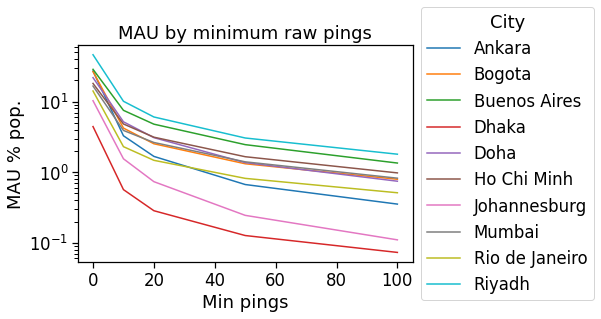

In [12]:
g = sns.lineplot(x='Min pings',
                 y='MAU % pop.',
                 hue='City',
                 hue_order=city_order,
                 # style='Good data',
                 # style_order=[True,False],
                 data=df_mau,
            )
plt.semilogy()
plt.title('MAU by minimum raw pings')

# Put the legend out of the figure
g.legend(loc='center left',
         title='City',
         bbox_to_anchor=(1, 0.5))
plt.savefig(os.path.join(OUT_FOLDER, 'mau_users_min_pings.pdf'), bbox_inches='tight')

In [13]:
df_mau[df_mau['Min pings']==10][['City','MAU % pop.']]

City  MAU % pop.
1           Mumbai    3.903885
6           Ankara    3.279650
11          Riyadh   10.101880
16  Rio de Janeiro    2.299128
21            Doha    5.172929
26           Dhaka    0.566093
31          Bogota    4.214564
36    Buenos Aires    7.519973
41     Ho Chi Minh    4.818226
46    Johannesburg    1.548008

In [14]:
df_mau_homeWork = None
for city, data in DATA_CITIES.items():
    tmp_stats = data['df_cnt_hw_locs']
    tmp_min_days = tmp_stats['n_days'].min()
    
    tmp_df = tmp_stats.query('n_days ==%d & n_hours == 10' % max(tmp_min_days, 4)).copy(deep=True)
    tmp_df['City'] = data['name']
    tmp_df['MAU % pop.'] = tmp_df['n_users'] / data['population'] * 100
    tmp_df['MAU with home % pop.'] = tmp_df['with_home_users'] / data['population'] * 100
    tmp_df['MAU with work % pop.'] = tmp_df['with_work_users'] / data['population'] * 100
    
    df_mau_homeWork = pd.concat((tmp_df, df_mau_homeWork),
                                sort=True, ignore_index=True)
df_mau_homeWork.head(0)

Empty DataFrame
Columns: [City, MAU % pop., MAU with home % pop., MAU with work % pop., delta_count, delta_duration, home_work_same_area_users, home_work_same_area_users_frac, n_days, n_hours, n_users, tot_duration, with_home_users, with_work_users]
Index: []

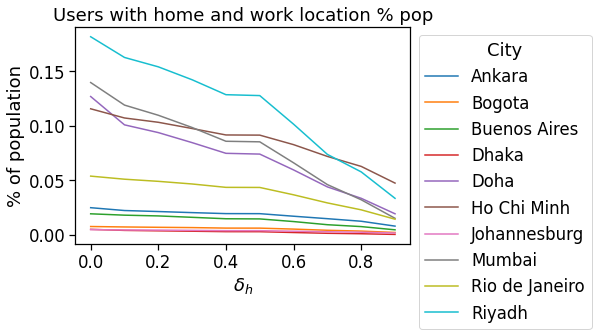

In [15]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
sns.lineplot(x='delta_duration', y='MAU % pop.',
             data=df_mau_homeWork,
             hue='City',
             hue_order=city_order,
            )
# plt.semilogy()
plt.legend(loc=2, bbox_to_anchor=[1,1], title='City',)
plt.xlabel(r"$\delta_h$")
plt.ylabel("% of population")
plt.title('Users with home and work location % pop')
fig.savefig(os.path.join(OUT_FOLDER, 'mau_users_with_home_work.pdf'), bbox_inches='tight')

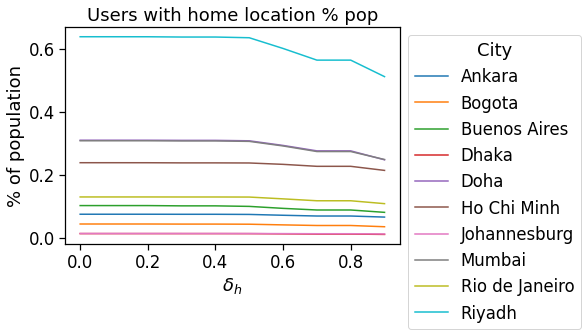

In [16]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
sns.lineplot(x='delta_duration', y='MAU with home % pop.',
             data=df_mau_homeWork,
             hue='City',
             hue_order=city_order,
            )
# plt.semilogy()
plt.legend(loc=2, bbox_to_anchor=[1,1], title='City',)
plt.xlabel(r"$\delta_h$")
plt.ylabel("% of population")
plt.title('Users with home location % pop')
fig.savefig(os.path.join(OUT_FOLDER, 'mau_users_with_home.pdf'), bbox_inches='tight')

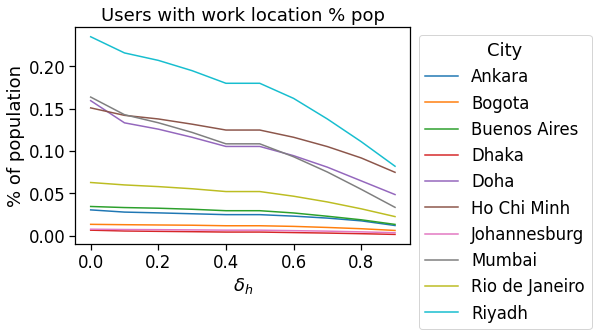

In [17]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
sns.lineplot(x='delta_duration', y='MAU with work % pop.',
             data=df_mau_homeWork,
             hue='City',
             hue_order=city_order,
            )
# plt.semilogy()
plt.legend(loc=2, bbox_to_anchor=[1,1], title='City',)
plt.xlabel(r"$\delta_h$")
plt.ylabel("% of population")
plt.title('Users with work location % pop')
fig.savefig(os.path.join(OUT_FOLDER, 'mau_users_with_work.pdf'), bbox_inches='tight')

## Spatial structure

We test the universality of the spatial structure of the cities by comparing the functioning of the different indicators in the different context.

In [1]:
min_count_per_area = 10

In [19]:
df_spatial_areas = None
for city, data in DATA_CITIES.items():
    if not data['to_do']: continue
    
    tmp_df = data['gdf'].query('rog_home_count >= @min_count_per_area').copy(deep=True)
    tmp_df['City'] = data['name']
    tmp_df['cbd_dist_norm'] = tmp_df['cbd_dist'] / data['aoi_radius_km']
    tmp_df['cbd_dist_bin_norm'] = np.round(tmp_df['cbd_dist_norm'], decimals=1)

    df_spatial_areas = pd.concat((tmp_df, df_spatial_areas),
                                sort=True, ignore_index=True)
df_spatial_areas.head(0)

Empty GeoDataFrame
Columns: [City, avg_realD_frac_osmD, avg_realT_frac_osmT, bottom, cbd_dist, cbd_dist_bin, cbd_dist_bin_norm, cbd_dist_norm, cluster, geometry, home_work_osrm_dist_avg, home_work_osrm_dist_max, home_work_osrm_dist_min, home_work_osrm_dist_std, home_work_osrm_time_avg, home_work_osrm_time_max, home_work_osrm_time_min, home_work_osrm_time_std, home_work_ratio, home_work_straight_dist_avg, home_work_straight_dist_max, home_work_straight_dist_min, home_work_straight_dist_std, id, left, nUsers, n_homes, n_works, right, rog_count, rog_home_count, rog_home_max, rog_home_mean, rog_home_min, rog_home_std, rog_max, rog_mean, rog_min, rog_std, rog_total_count, rog_total_max, rog_total_mean, rog_total_min, rog_total_std, scope, speed_trips_hw_avg, speed_trips_hw_max, speed_trips_hw_min, speed_trips_hw_std, speed_trips_wh_avg, speed_trips_wh_max, speed_trips_wh_min, speed_trips_wh_std, tile_ID, time_trips_hw_avg, time_trips_hw_max, time_trips_hw_min, time_trips_hw_std, time_trips_wh_avg, time_trips_wh_max, time_trips_wh_min, time_trips_wh_std, top, ttd_count, ttd_max, ttd_mean, ttd_min, ttd_std, work_home_osrm_dist_avg, work_home_osrm_dist_max, work_home_osrm_dist_min, work_home_osrm_dist_std, work_home_osrm_time_avg, work_home_osrm_time_max, work_home_osrm_time_min, work_home_osrm_time_std]
Index: []

[0 rows x 76 columns]

In [20]:
df_spatial_users = None
for city, data in DATA_CITIES.items():
    if not data['to_do']: continue
    
    tmp_df = data['cleaned_user_stats_table_df'].copy(deep=True)
    tmp_df['City'] = data['name']
    
    tmp_df['aoi_radius_km'] = data['aoi_radius_km']
    
    tmp_df['cbd_dist_norm'] = tmp_df['cbd_dist'] / tmp_df['aoi_radius_km']
    tmp_df['cbd_dist_bin_norm'] = np.round(tmp_df['cbd_dist_norm'], decimals=1)
    
    tmp_df['closest_cbd_dist_norm'] = tmp_df['closest_cbd_dist'] / tmp_df['aoi_radius_km']
    tmp_df['closest_cbd_dist_bin_norm'] = np.round(tmp_df['closest_cbd_dist_norm'], decimals=1)

    df_spatial_users = pd.concat((tmp_df, df_spatial_users),
                                sort=True, ignore_index=True)
df_spatial_users.head(0)

Empty DataFrame
Columns: [City, aoi_radius_km, avg, avg_realD_frac_osmD, avg_realT_frac_osmT, cbd_dist, cbd_dist_bin, cbd_dist_bin_norm, cbd_dist_norm, closest_cbd_dist, closest_cbd_dist_bin, closest_cbd_dist_bin_norm, closest_cbd_dist_norm, closest_cbd_idx, com_home_lat, com_home_lng, com_total_lat, com_total_lng, daysActive, daysSpanned, home_loc_ID, home_pings, home_work_osrm_dist, home_work_osrm_dist_km, home_work_osrm_time, home_work_osrm_time_h, home_work_straight_dist, lat_home, lat_work, lng_home, lng_work, max_day, min_day, n_pings, pings, pingsPerDay, rog, rog_home, rog_total, speed_trips_hw, speed_trips_wh, time_trips_hw, time_trips_wh, tot_pings, ttd, work_home_osrm_dist, work_home_osrm_time, work_loc_ID, work_pings]
Index: []

[0 rows x 49 columns]

In [21]:
city_todo_order = sorted(list(df_spatial_areas['City'].unique()))

In [22]:
def plotLines(
    x, y, data,
    hue='City',
    hue_order=city_todo_order,
    figsize=(12,5),
    xlabel='ylabel',
    ylabel='xlabel',
    title=None,
    xlim=None,
    ylim=None,
    kwargs_leg={},
    tight=True,
    **kwargs,
):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    g = sns.lineplot(data=data,
                 x=x,
                 y=y,
                 hue=hue,
                 hue_order=hue_order,
                ax=ax,
                 **kwargs
    )
    g.legend(loc=2, bbox_to_anchor=[1,1], title=hue, **kwargs_leg)
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    if tight:
        fig.tight_layout()
    return fig, ax

### Radius of Gyration (ROG) vs. distance to Central Business District

In this first plot we observe that Doha and Riyadh display a strong monocentric pattern, whereas the other cities feature a non-monotonic increase of the ROG (centered on the users' homes) as we move away from the CBD. 

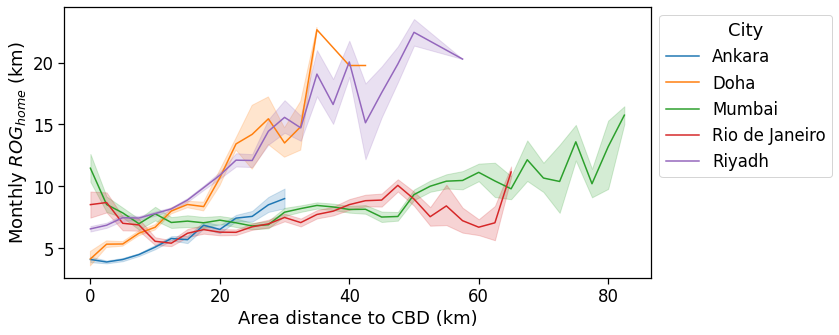

In [23]:
fig, ax = plotLines(
    data=df_spatial_areas,
    x='cbd_dist_bin',
    y='rog_home_mean',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'Area distance to CBD (km)',
    ylabel=r'Monthly $ROG_{home}$ (km)',
    # title=r'Per area $ROG_{home}$ vs. distance to CBD'
)
fig.savefig(os.path.join(OUT_FOLDER, 'rog_home_month_area_cbd.pdf'), bbox_inches='tight')

The same holds if we normalize the distance from the CBD by the city's radius.

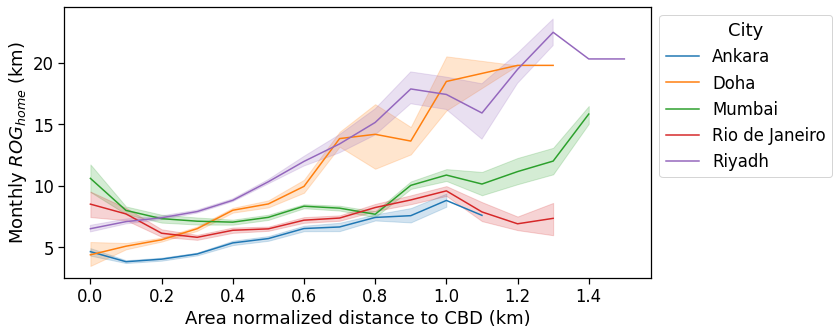

In [24]:
fig, ax = plotLines(
    data=df_spatial_areas,
    x='cbd_dist_bin_norm',
    y='rog_home_mean',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'Area normalized distance to CBD (km)',
    ylabel=r'Monthly $ROG_{home}$ (km)',
    # title=r'Per area $ROG_{home}$ vs. normalized distance to CBD'
)
fig.savefig(os.path.join(OUT_FOLDER, 'rog_home_month_area_cbd_norm.pdf'), bbox_inches='tight')

The same holds if we measure the ROG with respect to the user's baricenter. 

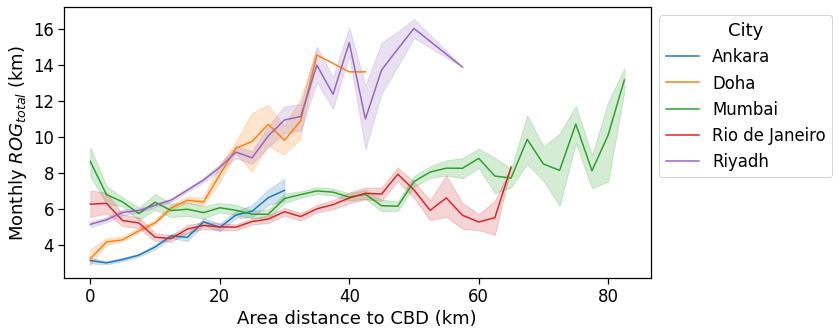

In [25]:
fig, ax = plotLines(
    data=df_spatial_areas,
    x='cbd_dist_bin',
    y='rog_total_mean',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'Area distance to CBD (km)',
    ylabel=r'Monthly $ROG_{total}$ (km)',
    # title=r'Per area $ROG_{total}$ vs. distance to CBD'
)
fig.savefig(os.path.join(OUT_FOLDER, 'rog_total_month_area_cbd.pdf'), bbox_inches='tight')

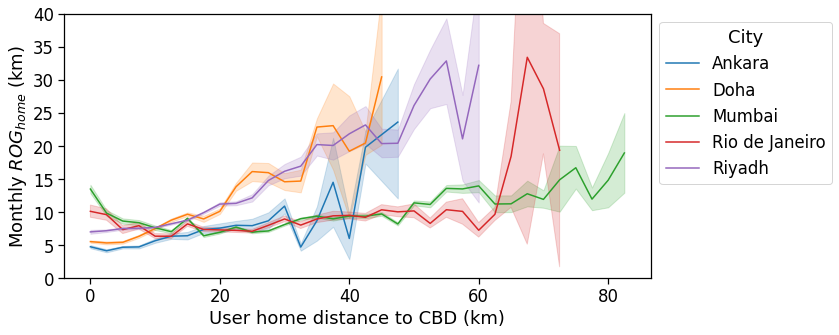

In [26]:
fig, ax = plotLines(
    data=df_spatial_users,
    x='cbd_dist_bin',
    y='rog_home',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'User home distance to CBD (km)',
    ylabel=r'Monthly $ROG_{home}$ (km)',
    # title=r'Per user $ROG_{home}$ vs. home distance to CBD',
    ylim=(0,40),
)
fig.savefig(os.path.join(OUT_FOLDER, 'rog_home_month_user_cbd.pdf'), bbox_inches='tight')

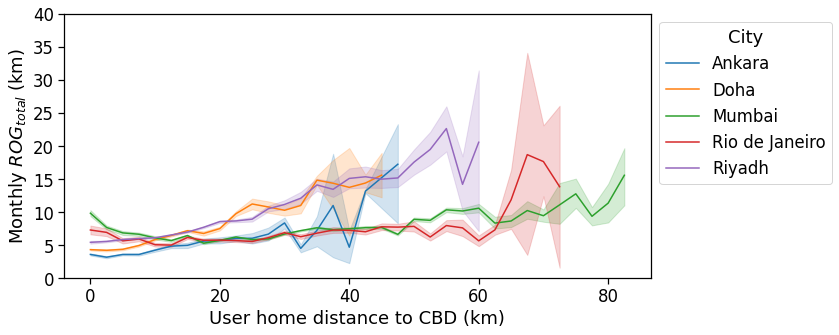

In [27]:
fig, ax = plotLines(
    data=df_spatial_users,
    x='cbd_dist_bin',
    y='rog_total',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'User home distance to CBD (km)',
    ylabel=r'Monthly $ROG_{total}$ (km)',
    # title=r'Per user $ROG_{total}$ vs. home distance to CBD',
    ylim=(0,40),
)
fig.savefig(os.path.join(OUT_FOLDER, 'rog_total_month_user_cbd.pdf'), bbox_inches='tight')

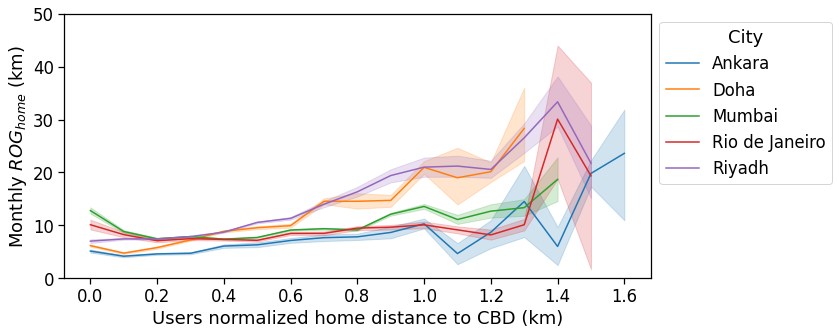

In [28]:
fig, ax = plotLines(
    data=df_spatial_users,
    x='cbd_dist_bin_norm',
    y='rog_home',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'Users normalized home distance to CBD (km)',
    ylabel=r'Monthly $ROG_{home}$ (km)',
    # title=r'Per user $ROG_{home}$ vs. normalized home distance to CBD',
    ylim=(0,50),
)
fig.savefig(os.path.join(OUT_FOLDER, 'rog_home_month_user_cbd_norm.pdf'), bbox_inches='tight')

### Radius of Gyration (ROG) vs. distance to Business District closest to workplace

If we instead compte the average ROG for users with the home at a given distance from the BD closest to the user's workplace, all the cities collapse on a single curve: the new definition of distance from user-dependent BD instead of the unique CBD cancels out the polycentric structure of the city and all the signals lie on a single, monotonically increasing line. 

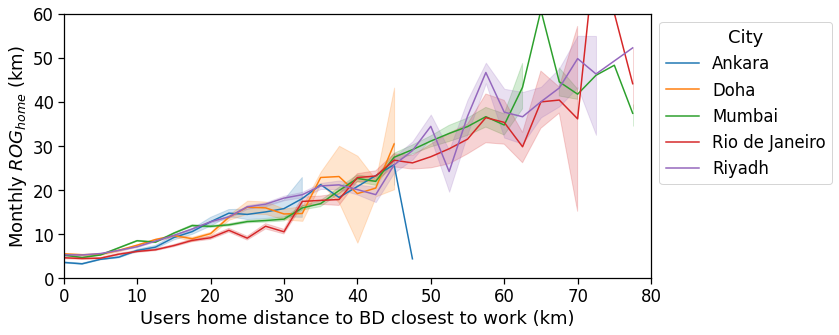

In [29]:
fig, ax = plotLines(
    data=df_spatial_users,
    x='closest_cbd_dist_bin',
    y='rog_home',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'Users home distance to BD closest to work (km)',
    ylabel=r'Monthly $ROG_{home}$ (km)',
    # title=r'Per user $ROG_{home}$ vs. home distance to BD closest to workplace',
    xlim=[0,80],
    ylim=(0,60),
)
fig.savefig(os.path.join(OUT_FOLDER, 'rog_home_month_user_cbd_closest.pdf'), bbox_inches='tight')

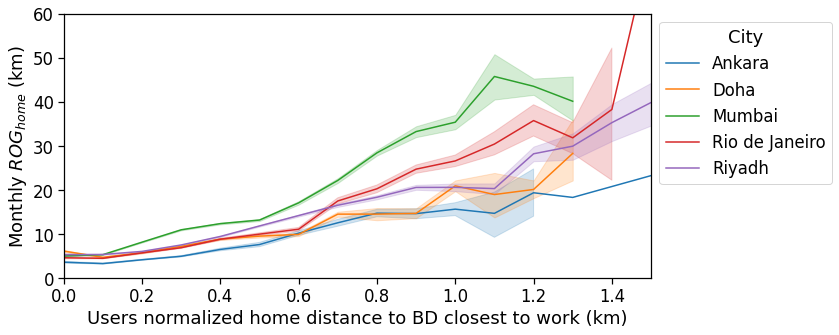

In [30]:
fig, ax = plotLines(
    data=df_spatial_users,
    x='closest_cbd_dist_bin_norm',
    y='rog_home',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'Users normalized home distance to BD closest to work (km)',
    ylabel=r'Monthly $ROG_{home}$ (km)',
    # title=r'Per user $ROG_{home}$ vs. normalized home distance to BD closest to workplace',
    xlim=[0,1.5],
    ylim=(0,60),
)
fig.savefig(os.path.join(OUT_FOLDER, 'rog_home_month_user_cbd_closest_norm.pdf'), bbox_inches='tight')

### Daily Radius of Gyration (ROG) vs. distance to Business District closest to workplace

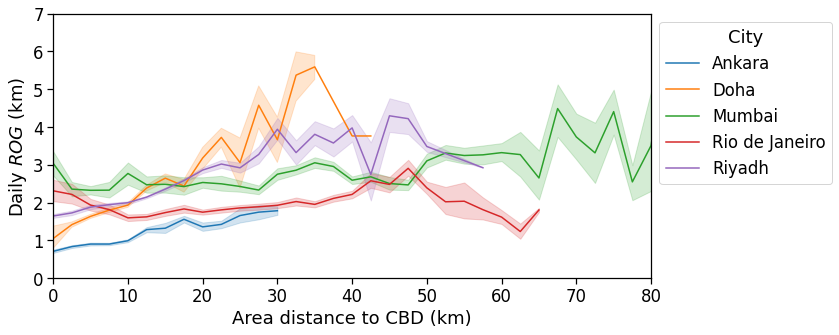

In [31]:
fig, ax = plotLines(
    data=df_spatial_areas,
    x='cbd_dist_bin',
    y='rog_mean',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'Area distance to CBD (km)',
    ylabel=r'Daily $ROG$ (km)',
    # title=r'Per area $ROG$ vs. distance to CBD',
    xlim=[0,80],
    ylim=(0,7),
)
fig.savefig(os.path.join(OUT_FOLDER, 'rog_daily_area_cbd.pdf'), bbox_inches='tight')

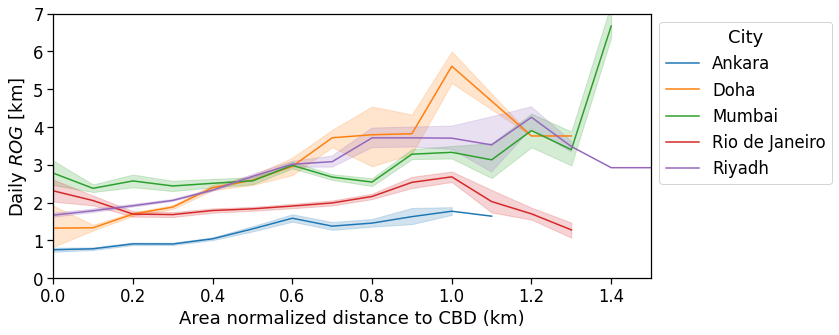

In [32]:
fig, ax = plotLines(
    data=df_spatial_areas,
    x='cbd_dist_bin_norm',
    y='rog_mean',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'Area normalized distance to CBD (km)',
    ylabel=r'Daily $ROG$ [km]',
    # title=r'Per area $ROG$ vs. normalized distance to CBD',
    ylim=(0,7),
    xlim=[0,1.5]
)
fig.savefig(os.path.join(OUT_FOLDER, 'rog_daily_area_cbd_norm.pdf'), bbox_inches='tight')

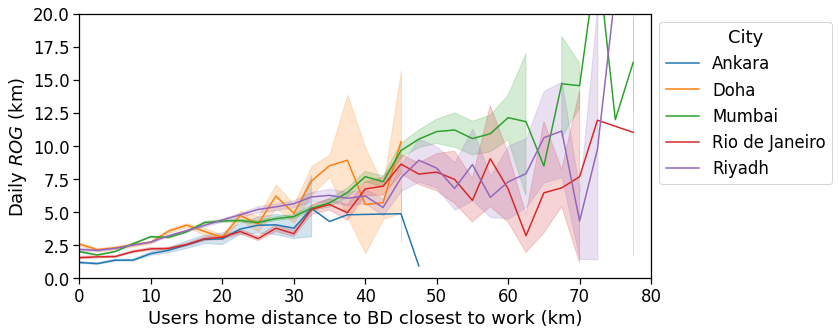

In [33]:
fig, ax = plotLines(
    data=df_spatial_users,
    x='closest_cbd_dist_bin',
    y='rog',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'Users home distance to BD closest to work (km)',
    ylabel=r'Daily $ROG$ (km)',
    # title=r'Per user $ROG$ vs. home distance to BD closest to workplace',
    ylim=(0,20),
    xlim=[0,80],
)
fig.savefig(os.path.join(OUT_FOLDER, 'rog_daily_user_cbd_closest.pdf'), bbox_inches='tight')

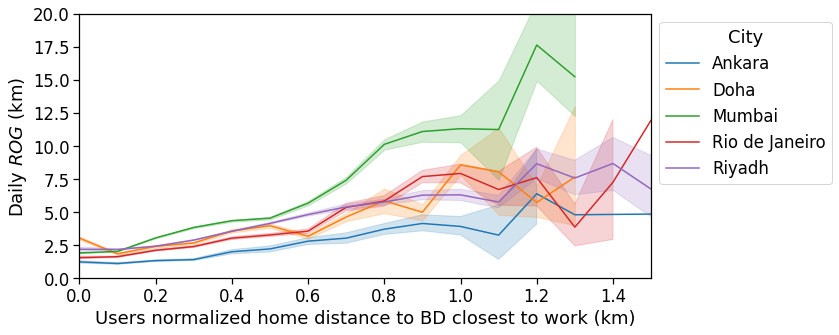

In [34]:
fig, ax = plotLines(
    data=df_spatial_users,
    x='closest_cbd_dist_bin_norm',
    y='rog',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'Users normalized home distance to BD closest to work (km)',
    ylabel=r'Daily $ROG$ (km)',
    # title=r'Per user daily $ROG$ vs. normalized home distance to BD closest to workplace',
    xlim=[0,1.5],
    ylim=(0,20),
)
fig.savefig(os.path.join(OUT_FOLDER, 'rog_daily_user_cbd_closest_norm.pdf'), bbox_inches='tight')

### Total Traveled Distance (TTD) vs. distance to Central Business District

For this and the next indicators we observe the same behavior.
We simply reports all the plots to display the insights gained with the spatial structure analyses of the previous notebook.

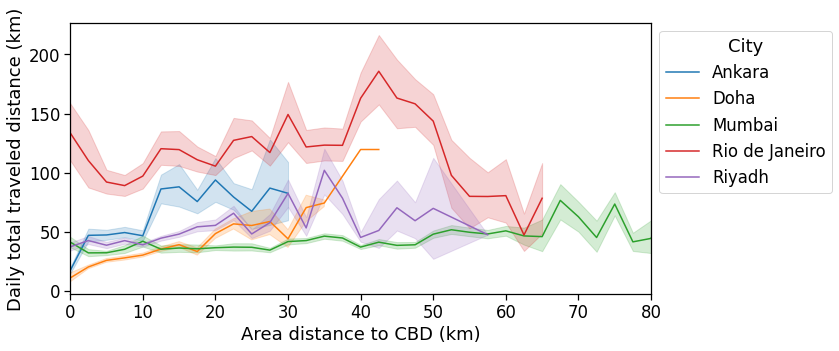

In [62]:
fig, ax = plotLines(
    data=df_spatial_areas,
    x='cbd_dist_bin',
    y='ttd_mean',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'Area distance to CBD (km)',
    ylabel='Daily total traveled distance (km)',
    # title=r'Per area daily $TTD$ vs. distance to CBD'
    xlim=[0,80],
)
fig.savefig(os.path.join(OUT_FOLDER, 'ttd_daily_area_cbd.pdf'), bbox_inches='tight')

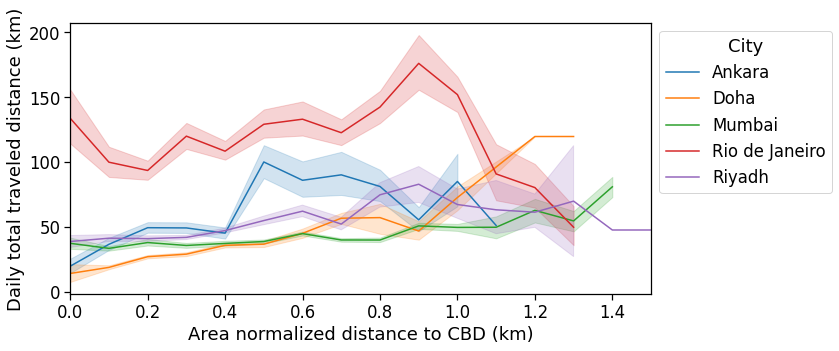

In [63]:
fig, ax = plotLines(
    data=df_spatial_areas,
    x='cbd_dist_bin_norm',
    y='ttd_mean',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'Area normalized distance to CBD (km)',
    ylabel=r'Daily total traveled distance (km)',
    # title=r'Per area daily $TTD$ vs. normalized distance to CBD'
    xlim=[0,1.5],
)
fig.savefig(os.path.join(OUT_FOLDER, 'ttd_daily_area_cbd_norm.pdf'), bbox_inches='tight')

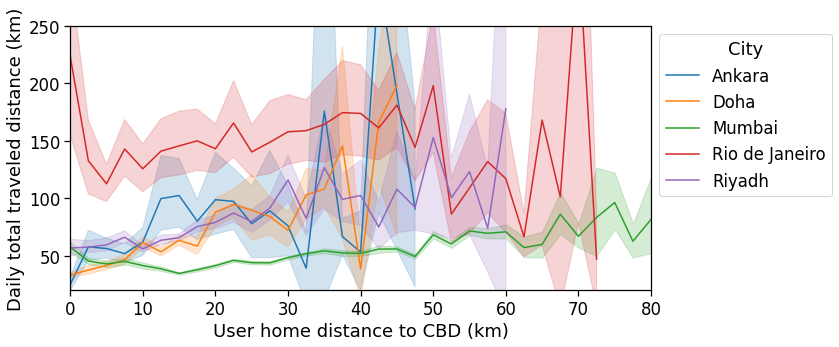

In [37]:
fig, ax = plotLines(
    data=df_spatial_users,
    x='cbd_dist_bin',
    y='ttd',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'User home distance to CBD (km)',
    ylabel=r'Daily total traveled distance (km)',
    # title=r'Per user $TTD$ vs. home distance to CBD',
    xlim=[0,80],
    ylim=(20,250),
)
fig.savefig(os.path.join(OUT_FOLDER, 'ttd_daily_user_cbd.pdf'), bbox_inches='tight')

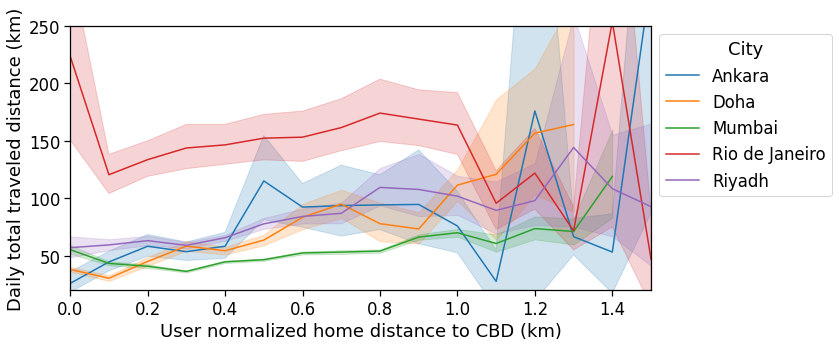

In [38]:
fig, ax = plotLines(
    data=df_spatial_users,
    x='cbd_dist_bin_norm',
    y='ttd',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'User normalized home distance to CBD (km)',
    ylabel=r'Daily total traveled distance (km)',
    # title=r'Per user $TTD$ vs. normalized home distance to CBD',
    xlim=[0,1.5],
    ylim=(20,250),
)
fig.savefig(os.path.join(OUT_FOLDER, 'ttd_daily_user_cbd_norm.pdf'), bbox_inches='tight')

### Total Traveled Distance (TTD) vs. distance to Business District closest to workplace

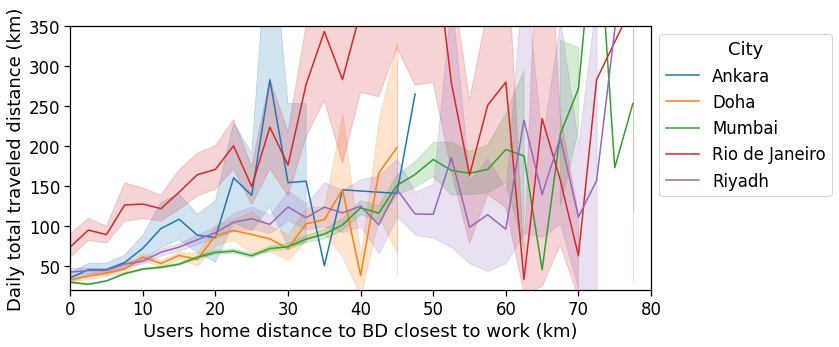

In [39]:
fig, ax = plotLines(
    data=df_spatial_users,
    x='closest_cbd_dist_bin',
    y='ttd',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'Users home distance to BD closest to work (km)',
    ylabel=r'Daily total traveled distance (km)',
    # title=r'Per user daily $TTD$ vs. home distance to BD closest to workplace',
    xlim=[0,80],
    ylim=(20,350),
)
fig.savefig(os.path.join(OUT_FOLDER, 'ttd_daily_user_cbd_closest.pdf'), bbox_inches='tight')

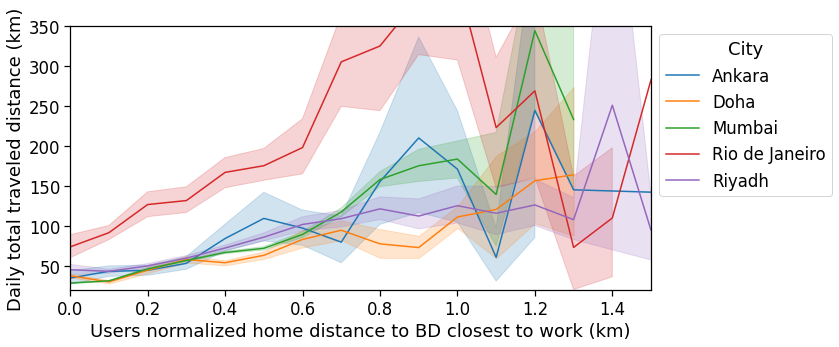

In [40]:
fig, ax = plotLines(
    data=df_spatial_users,
    x='closest_cbd_dist_bin_norm',
    y='ttd',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'Users normalized home distance to BD closest to work (km)',
    ylabel=r'Daily total traveled distance (km)',
    # title=r'Per user daily $TTD$ vs. normalized home distance to BD closest to workplace',
    xlim=[0,1.5],
    ylim=(20,350),
)
fig.savefig(os.path.join(OUT_FOLDER, 'ttd_daily_user_cbd_closest_norm.pdf'), bbox_inches='tight')

### Home-work distance vs. distance to Central Business District

In [41]:
df_spatial_areas['home_work_osrm_dist_avg_km'] = df_spatial_areas['home_work_osrm_dist_avg'] / 1e3

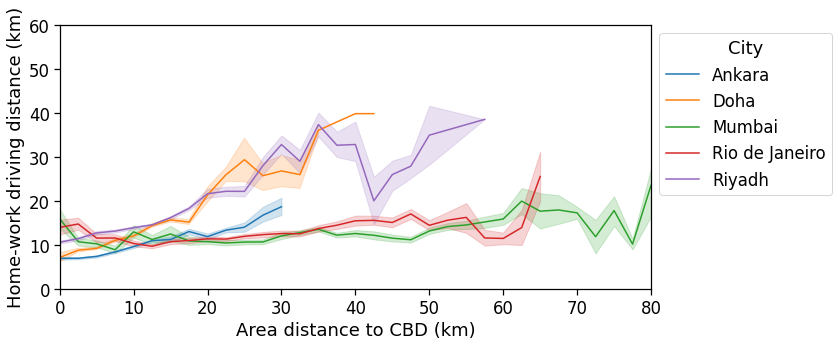

In [42]:
fig, ax = plotLines(
    data=df_spatial_areas,
    x='cbd_dist_bin',
    y='home_work_osrm_dist_avg_km',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'Area distance to CBD (km)',
    ylabel=r'Home-work driving distance (km)',
    # title=r'Per area $D^{OSRM}_{home,work}$ vs. normalized distance to CBD',
    xlim=[0,80],
    ylim=(0,60),
)
fig.savefig(os.path.join(OUT_FOLDER, 'home_work_dist_area_cbd.pdf'), bbox_inches='tight')

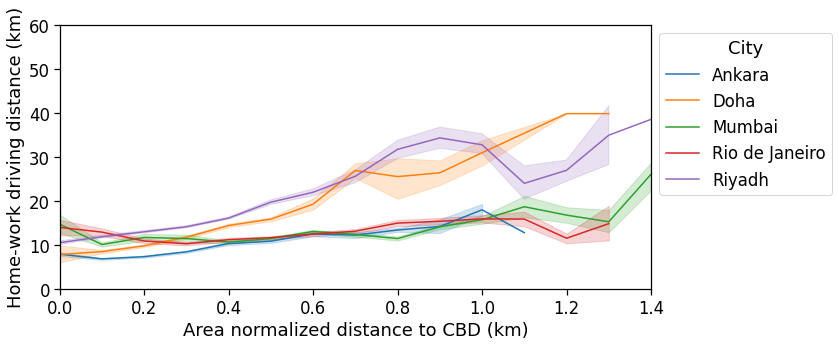

In [43]:
fig, ax = plotLines(
    data=df_spatial_areas,
    x='cbd_dist_bin_norm',
    y='home_work_osrm_dist_avg_km',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'Area normalized distance to CBD (km)',
    ylabel=r'Home-work driving distance (km)',
    # title=r'Per area $D^{OSRM}_{home,work}$ vs. normalized distance to CBD',
    xlim=[0,1.4],
    ylim=(0,60),
)
fig.savefig(os.path.join(OUT_FOLDER, 'home_work_dist_area_cbd_norm.pdf'), bbox_inches='tight')

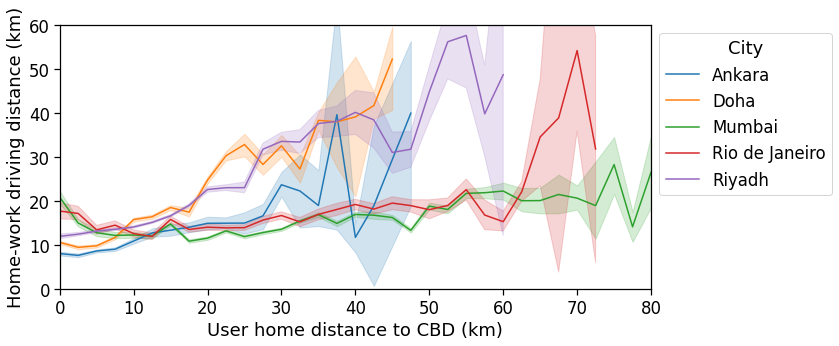

In [44]:
fig, ax = plotLines(
    data=df_spatial_users,
    x='cbd_dist_bin',
    y='home_work_osrm_dist_km',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'User home distance to CBD (km)',
    ylabel=r'Home-work driving distance (km)',
    # title=r'Per user $D^{OSRM}_{home,work}$ vs. distance to CBD',
    xlim=[0,80],
    ylim=(0,60),
)
fig.savefig(os.path.join(OUT_FOLDER, 'home_work_dist_user_cbd.pdf'), bbox_inches='tight')

### Home-work distance vs. distance to Business District closest to homeplace

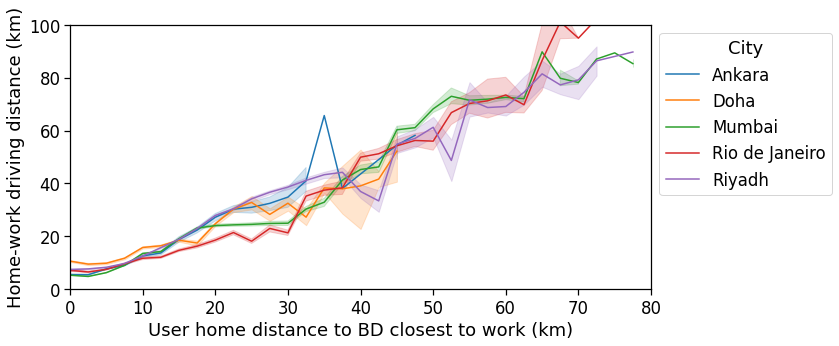

In [45]:
fig, ax = plotLines(
    data=df_spatial_users,
    x='closest_cbd_dist_bin',
    y='home_work_osrm_dist_km',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'User home distance to BD closest to work (km)',
    ylabel=r'Home-work driving distance (km)',
    # title=r'Per user $D^{OSRM}_{home,work}$ vs. home distance to BD closest to workplace',
    xlim=[0,80],
    ylim=(0,100),
)
fig.savefig(os.path.join(OUT_FOLDER, 'home_work_dist_user_cbd_closest.pdf'), bbox_inches='tight')

### Home-work distance ratio (Euclidean/osrm) vs. distance to Central Business District

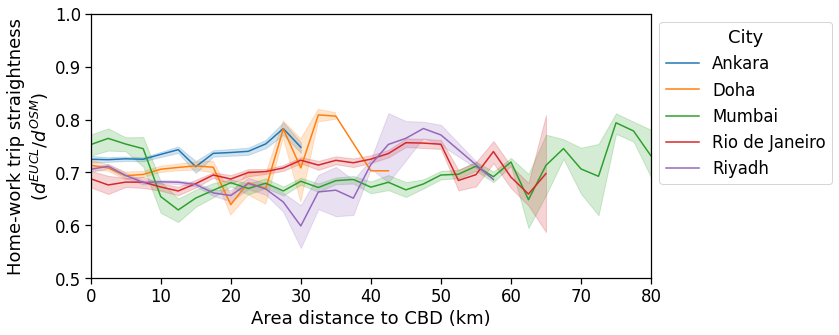

In [46]:
fig, ax = plotLines(
    data=df_spatial_areas,
    x='cbd_dist_bin',
    y='avg_realD_frac_osmD',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'Area distance to CBD (km)',
    ylabel='Home-work trip straightness\n' + r'$(d^{EUCL} / d^{OSM})$',
    # title=r'Per area home-work $D^{EUCL} / D^{OSRM}$ distance vs. norm. distance to CBD',
    xlim=[0,80],
    ylim=(.5,1.),
)
fig.savefig(os.path.join(OUT_FOLDER, 'home_work_dist_fraction_area_cbd.pdf'), bbox_inches='tight')

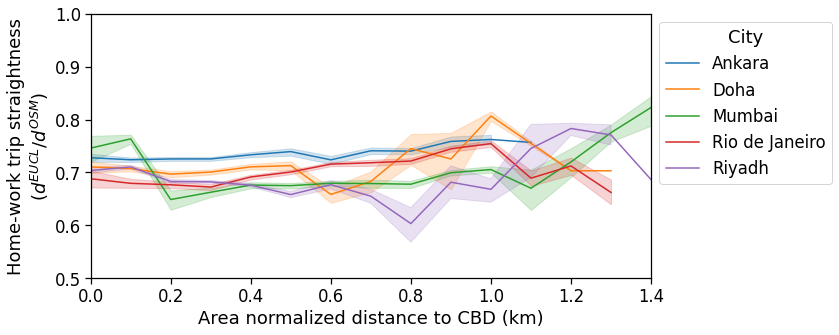

In [47]:
fig, ax = plotLines(
    data=df_spatial_areas,
    x='cbd_dist_bin_norm',
    y='avg_realD_frac_osmD',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'Area normalized distance to CBD (km)',
    ylabel='Home-work trip straightness\n' + r'$(d^{EUCL} / d^{OSM})$',
    # title=r'Per area home-work $D^{EUCL} / D^{OSRM}$ distance vs. norm. distance to CBD',
    xlim=[0,1.4],
    ylim=(.5,1.),
)
fig.savefig(os.path.join(OUT_FOLDER, 'home_work_dist_fraction_area_cbd_norm.pdf'), bbox_inches='tight')

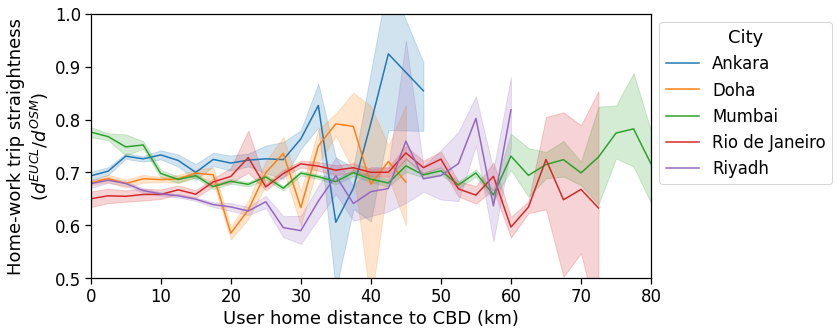

In [48]:
fig, ax = plotLines(
    data=df_spatial_users,
    x='cbd_dist_bin',
    y='avg_realD_frac_osmD',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'User home distance to CBD (km)',
    ylabel='Home-work trip straightness\n' + r'$(d^{EUCL} / d^{OSM})$',
    # title=r'Per user home-work $D^{EUCL} / D^{OSRM}$ distance vs. home distance to CBD',
    xlim=[0,80],
    ylim=(.5,1.),
)
fig.savefig(os.path.join(OUT_FOLDER, 'home_work_dist_fraction_user_cbd.pdf'), bbox_inches='tight')

### Home-work distance ratio (Euclidean/osrm) vs. distance to Business District closest to workplace

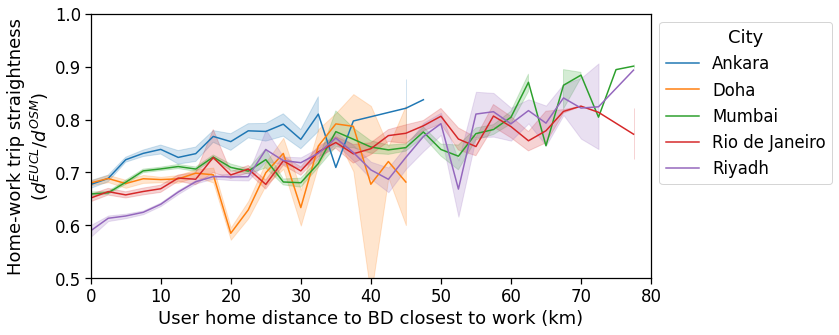

In [49]:
fig, ax = plotLines(
    data=df_spatial_users,
    x='closest_cbd_dist_bin',
    y='avg_realD_frac_osmD',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'User home distance to BD closest to work (km)',
    ylabel='Home-work trip straightness\n' + r'$(d^{EUCL} / d^{OSM})$',
    # title=r'Per user home-work $D^{EUCL} / D^{OSRM}$ dist. vs. home dist. to BD closest to work',
    xlim=(0,80),
    ylim=(.5,1),
)
fig.savefig(os.path.join(OUT_FOLDER, 'home_work_dist_fraction_user_cbd_closest.pdf'), bbox_inches='tight')

### Home-work duration vs. distance to Central Business District

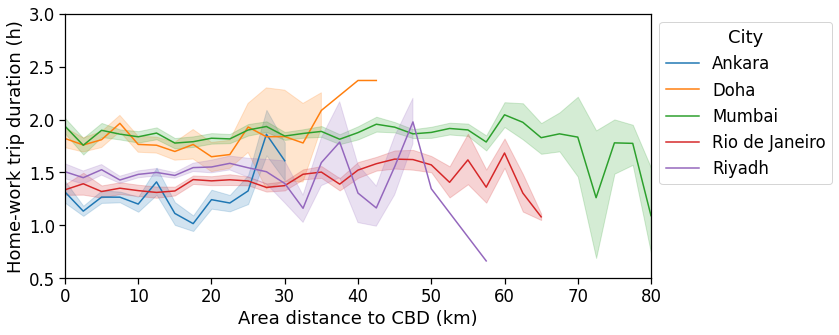

In [50]:
fig, ax = plotLines(
    data=df_spatial_areas,
    x='cbd_dist_bin',
    y='time_trips_hw_avg',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'Area distance to CBD (km)',
    ylabel='Home-work trip duration (h)',
    # title=r'Per area home-work $t^{REAL}$ duration vs. norm. distance to CBD',
    xlim=(0,80),
    ylim=(.5,3),
)
fig.savefig(os.path.join(OUT_FOLDER, 'home_work_duration_real_area_cbd.pdf'), bbox_inches='tight')

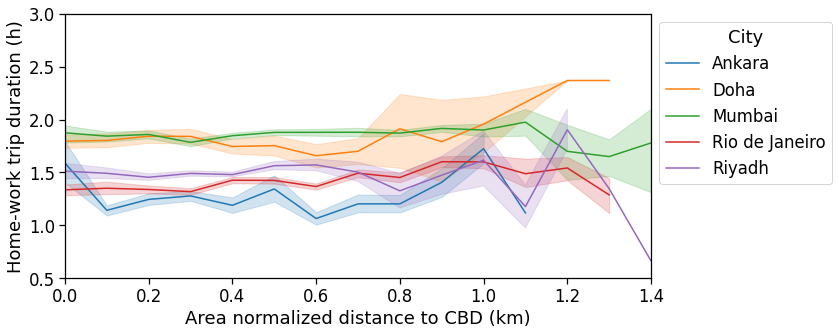

In [51]:
fig, ax = plotLines(
    data=df_spatial_areas,
    x='cbd_dist_bin_norm',
    y='time_trips_hw_avg',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'Area normalized distance to CBD (km)',
    ylabel='Home-work trip duration (h)',
    # title=r'Per area home-work $t^{REAL}$ duration vs. norm. distance to CBD',
    xlim=(0,1.4),
    ylim=(.5,3),
)
fig.savefig(os.path.join(OUT_FOLDER, 'home_work_duration_real_area_cbd_norm.pdf'), bbox_inches='tight')

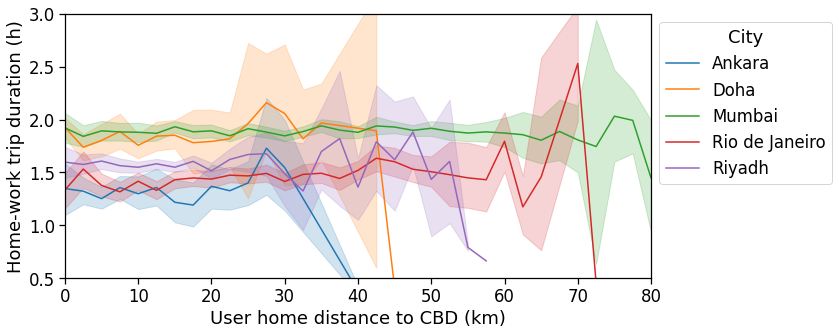

In [52]:
fig, ax = plotLines(
    data=df_spatial_users,
    x='cbd_dist_bin',
    y='time_trips_hw',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'User home distance to CBD (km)',
    ylabel='Home-work trip duration (h)',
    # title=r'Per user home-work $t^{REAL}$ duration vs. home distance to CBD',
    xlim=(0,80),
    ylim=(.5,3),
)
fig.savefig(os.path.join(OUT_FOLDER, 'home_work_duration_real_user_cbd.pdf'), bbox_inches='tight')

### Home-work duration vs. distance to Business District closest to workplace

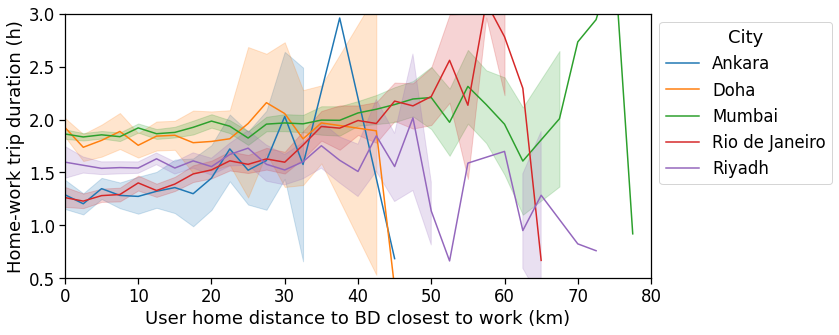

In [53]:
fig, ax = plotLines(
    data=df_spatial_users,
    x='closest_cbd_dist_bin',
    y='time_trips_hw',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'User home distance to BD closest to work (km)',
    ylabel='Home-work trip duration (h)',
    #  title=r'Per user home-work $t^{REAL}$ duration vs. home dist. to BD closest to workplace',
    xlim=(0,80),
    ylim=(.5,3),
)
fig.savefig(os.path.join(OUT_FOLDER, 'home_work_duration_real_user_cbd_closest.pdf'), bbox_inches='tight')

### Home-work duration ratio (real/osrm) vs. distance to Central Business District

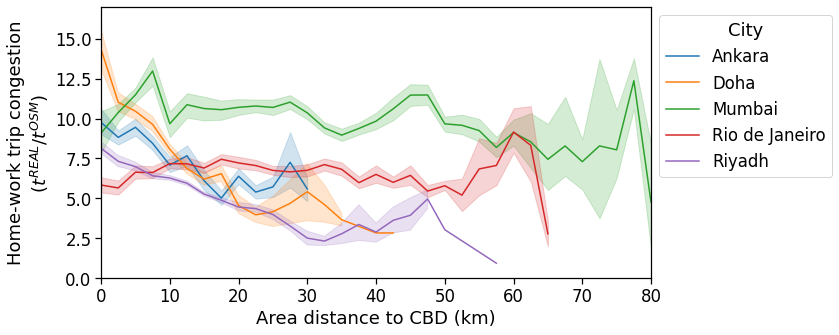

In [54]:
fig, ax = plotLines(
    data=df_spatial_areas,
    x='cbd_dist_bin',
    y='avg_realT_frac_osmT',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'Area distance to CBD (km)',
    ylabel='Home-work trip congestion\n' + r'($t^{REAL} / t^{OSM}$)',
    # title=r'Per area home-work $t^{REAL} / t^{OSRM}$ duration vs. norm. distance to CBD',
    xlim=(0,80),
    ylim=(0,17),
)
fig.savefig(os.path.join(OUT_FOLDER, 'home_work_duration_fraction_area_cbd.pdf'), bbox_inches='tight')

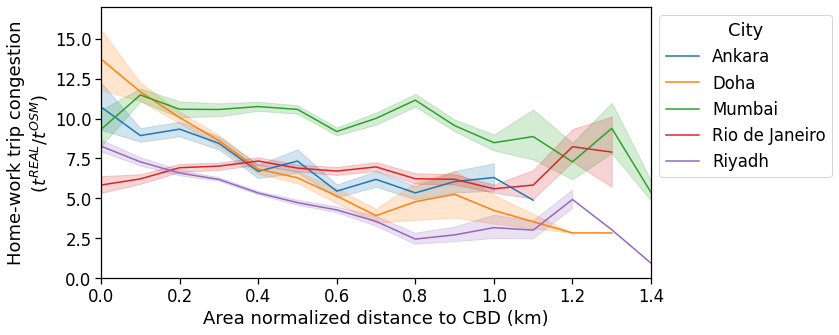

In [55]:
fig, ax = plotLines(
    data=df_spatial_areas,
    x='cbd_dist_bin_norm',
    y='avg_realT_frac_osmT',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'Area normalized distance to CBD (km)',
    ylabel='Home-work trip congestion\n' + r'($t^{REAL} / t^{OSM}$)',
    # title=r'Per area home-work $t^{REAL} / t^{OSRM}$ duration vs. norm. distance to CBD',
    xlim=(0,1.4),
    ylim=(0,17),
)
fig.savefig(os.path.join(OUT_FOLDER, 'home_work_duration_fraction_area_cbd_norm.pdf'), bbox_inches='tight')

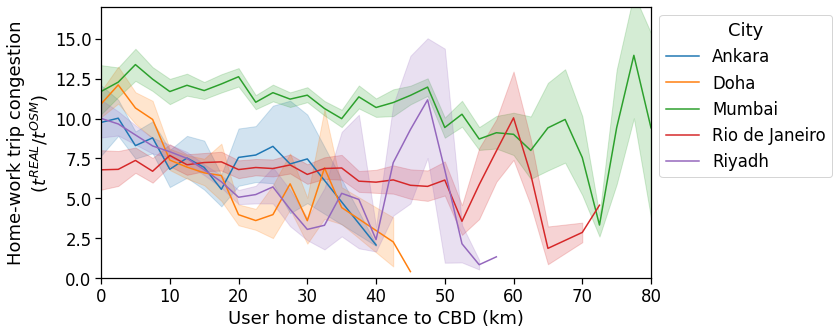

In [56]:
fig, ax = plotLines(
    data=df_spatial_users,
    x='cbd_dist_bin',
    y='avg_realT_frac_osmT',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'User home distance to CBD (km)',
    ylabel='Home-work trip congestion\n' + r'($t^{REAL} / t^{OSM}$)',
    # title=r'Per user home-work $t^{REAL} / t^{OSRM}$ duration vs. home distance to CBD',
    xlim=(0,80),
    ylim=(0,17),
)
fig.savefig(os.path.join(OUT_FOLDER, 'home_work_duration_fraction_user_cbd.pdf'), bbox_inches='tight')

### Home-work duration ratio (real/osrm) vs. distance to Business District closest to workplace

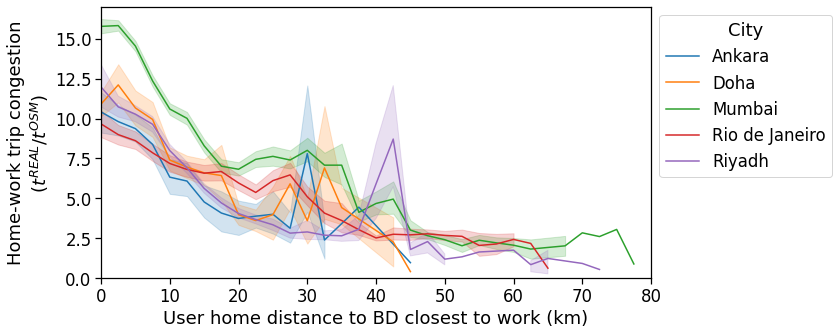

In [57]:
fig, ax = plotLines(
    data=df_spatial_users,
    x='closest_cbd_dist_bin',
    y='avg_realT_frac_osmT',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'User home distance to BD closest to work (km)',
    ylabel='Home-work trip congestion\n' + r'($t^{REAL} / t^{OSM}$)',
    #  title=r'Per user home-work $t^{REAL} / t^{OSRM}$ duration vs. home dist. to BD closest to workplace',
    xlim=(0,80),
    ylim=(0,17),
)
fig.savefig(os.path.join(OUT_FOLDER, 'home_work_duration_fraction_user_cbd_closest.pdf'), bbox_inches='tight')

### Home-work travel speed vs. distance to Central Business District

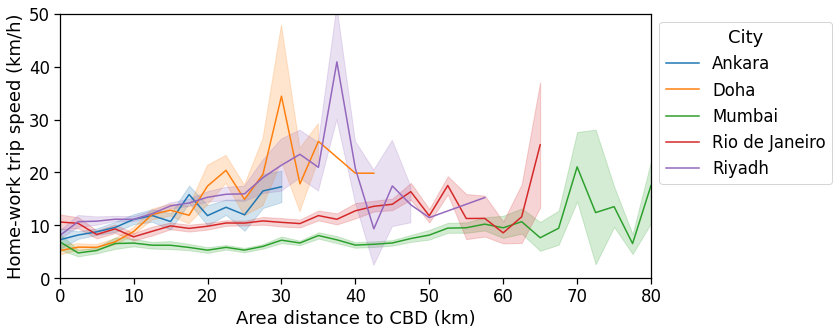

In [58]:
fig, ax = plotLines(
    data=df_spatial_areas,
    x='cbd_dist_bin',
    y='speed_trips_hw_avg',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'Area distance to CBD (km)',
    ylabel=r'Home-work trip speed (km/h)',
    # title=r'Per area home-work $v^{REAL}$ speed vs. norm. distance to CBD',
    xlim=(0,80),
    ylim=(0,50),
)
fig.savefig(os.path.join(OUT_FOLDER, 'home_work_speed_real_area_cbd.pdf'), bbox_inches='tight')

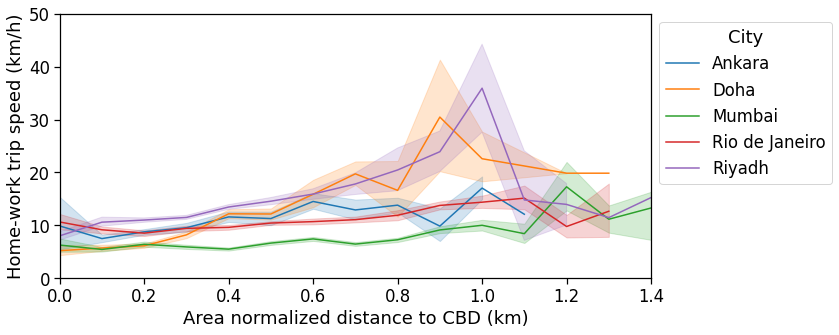

In [59]:
fig, ax = plotLines(
    data=df_spatial_areas,
    x='cbd_dist_bin_norm',
    y='speed_trips_hw_avg',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'Area normalized distance to CBD (km)',
    ylabel=r'Home-work trip speed (km/h)',
    # title=r'Per area home-work $v^{REAL}$ speed vs. norm. distance to CBD',
    xlim=(0,1.4),
    ylim=(0,50),
)
fig.savefig(os.path.join(OUT_FOLDER, 'home_work_speed_real_area_cbd_norm.pdf'), bbox_inches='tight')

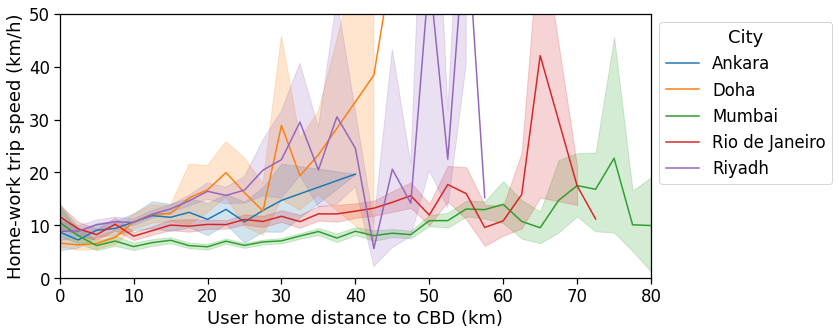

In [60]:
fig, ax = plotLines(
    data=df_spatial_users,
    x='cbd_dist_bin',
    y='speed_trips_hw',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'User home distance to CBD (km)',
    ylabel=r'Home-work trip speed (km/h)',
    # title=r'Per user home-work $v^{REAL}$ speed vs. home distance to CBD',
    xlim=(0,80),
    ylim=(0,50),
)
fig.savefig(os.path.join(OUT_FOLDER, 'home_work_speed_real_user_cbd.pdf'), bbox_inches='tight')

### Home-work travel speed vs. distance to Business District closest to workplace

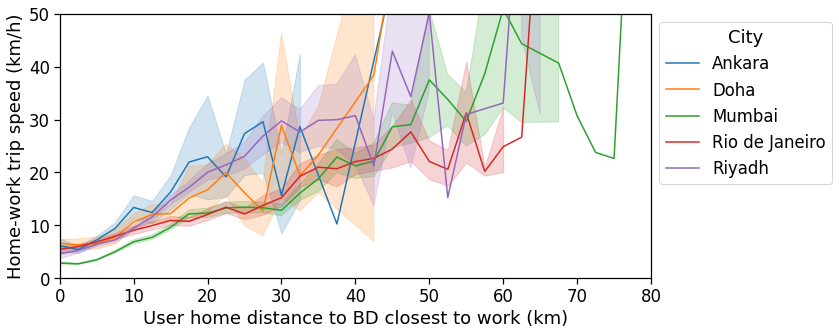

In [61]:
fig, ax = plotLines(
    data=df_spatial_users,
    x='closest_cbd_dist_bin',
    y='speed_trips_hw',
    hue='City',
    hue_order=city_todo_order,
    xlabel=r'User home distance to BD closest to work (km)',
    ylabel=r'Home-work trip speed (km/h)',
    # title=r'Per user home-work $v^{REAL}$ speed vs. home dist. to BD closest to workplace',
    xlim=(0,80),
    ylim=(0,50),
)
fig.savefig(os.path.join(OUT_FOLDER, 'home_work_speed_real_user_cbd_closest.pdf'), bbox_inches='tight')